In [1]:
import tensorflow as tf
import keras
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout,BatchNormalization,Activation,GlobalAveragePooling2D
from keras.utils import to_categorical

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import cv2
from PIL import Image

C:\anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from keras.utils.vis_utils import plot_model
from keras import backend as K
from keras.applications.inception_v3 import InceptionV3

In [3]:
parasitized=os.listdir('cell_images/Parasitized')
uninfected=os.listdir('cell_images/Uninfected')

In [4]:
data=[]
labels=[]

for a in parasitized:
    try:
        image=cv2.imread("cell_images/Parasitized/"+a)
        image_from_array=Image.fromarray(image,'RGB')
        size_image=image_from_array.resize((140,140))
        data.append(np.array(size_image))
        labels.append(1)
    except AttributeError:
        print("")
  

In [5]:
for b in uninfected:
    try:
        image=cv2.imread("cell_images/Uninfected/"+b)
        image_from_array=Image.fromarray(image,'RGB')
        size_image=image_from_array.resize((140,140))
        data.append(np.array(size_image))
        labels.append(0)
    except AttributeError:
        print("")

In [6]:
cells = np.array(data)
labels = np.array(labels)

np.save('Cells_140' , cells)
np.save('Labels_140' , labels)

In [7]:
cells=np.load('Cells_140.npy')
labels=np.load('Labels_140.npy')

In [8]:
n = np.arange(cells.shape[0])
np.random.shuffle(n)
cells = cells[n]
labels = labels[n]

In [9]:
from sklearn.model_selection import train_test_split

train_x , x , train_y , y = train_test_split(cells , labels , 
                                            test_size = 0.2 ,
                                            random_state = 111)

eval_x , test_x , eval_y , test_y = train_test_split(x , y , 
                                                    test_size = 0.5 , 
                                                    random_state = 111)

In [10]:
train_x.shape

(22046, 140, 140, 3)

In [11]:
img_rows=140
img_cols=140
num_classes=2
epochs = 10
batch_size = 128

In [12]:
if K.image_data_format() == 'channels_first':
    train_x = train_x.reshape(train_x.shape[0], 3, img_rows, img_cols)
    test_x = test_x.reshape(test_x.shape[0], 3, img_rows, img_cols)
    eval_x = eval_x.reshape(eval_x.shape[0], 3, img_rows, img_cols)
    input_shape = (3, img_rows, img_cols)
else:
    train_x = train_x.reshape(train_x.shape[0], img_rows, img_cols, 3)
    eval_x = eval_x.reshape(eval_x.shape[0], img_rows, img_cols, 3)
    test_x = test_x.reshape(test_x.shape[0], img_rows, img_cols, 3)
    input_shape = (img_rows, img_cols, 3)

In [13]:
test_y1=test_y
test_y1

array([1, 1, 1, ..., 0, 1, 0])

In [14]:
train_y = keras.utils.to_categorical(train_y, 2)
test_y = keras.utils.to_categorical(test_y, 2)
eval_y = keras.utils.to_categorical(eval_y, 2)

In [15]:
num_classes=len(np.unique(labels))
num_classes

2

In [38]:
inception=InceptionV3(include_top=False,weights='imagenet',input_shape=(140, 140, 3))
print(inception.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 140, 140, 3)  0                                            
__________________________________________________________________________________________________
conv2d_377 (Conv2D)             (None, 69, 69, 32)   864         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_377 (BatchN (None, 69, 69, 32)   96          conv2d_377[0][0]                 
__________________________________________________________________________________________________
activation_377 (Activation)     (None, 69, 69, 32)   0           batch_normalization_377[0][0]    
__________________________________________________________________________________________________
conv2d_378

In [39]:
#source:https://keras.io/applications/#fine-tune-inceptionv3-on-a-new-set-of-classes
x = inception.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(102, activation='relu')(x)
# and a logistic layer -- let's say we have 2 classes
predictions = Dense(2, activation='softmax')(x)


In [41]:
# this is the model we will train
model = Model(inputs=inception.input, outputs=predictions)

In [42]:
# Freeze the layers 
for layer in inception.layers:
    layer.trainable = False
 
#Check the trainable status of the individual layers
for layer in inception.layers:
    print(layer, layer.trainable)

<keras.engine.topology.InputLayer object at 0x00000168B72B9C50> False
<keras.layers.convolutional.Conv2D object at 0x00000168B72B9D30> False
<keras.layers.normalization.BatchNormalization object at 0x00000168B72B9DA0> False
<keras.layers.core.Activation object at 0x00000168B72B9E48> False
<keras.layers.convolutional.Conv2D object at 0x00000168ACFBAF28> False
<keras.layers.normalization.BatchNormalization object at 0x00000168ACF850F0> False
<keras.layers.core.Activation object at 0x00000168ACF2E4E0> False
<keras.layers.convolutional.Conv2D object at 0x00000168AA5AEA90> False
<keras.layers.normalization.BatchNormalization object at 0x00000168AA56BB38> False
<keras.layers.core.Activation object at 0x00000168B60673C8> False
<keras.layers.pooling.MaxPooling2D object at 0x00000168ACF783C8> False
<keras.layers.convolutional.Conv2D object at 0x00000168B618EE10> False
<keras.layers.normalization.BatchNormalization object at 0x00000168ACB7E160> False
<keras.layers.core.Activation object at 0x000

In [43]:
from keras.layers import Input, Flatten, Dense
from keras.models import Model

In [44]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False),
              metrics=['accuracy'])
model.fit(train_x, train_y,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(eval_x, eval_y))
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.


Train on 22046 samples, validate on 2756 samples
Epoch 1/10
22046/22046 [==============================] - 52s 2ms/step - loss: 0.4560 - acc: 0.8076 - val_loss: 8.1097 - val_acc: 0.4967
Epoch 2/10
22046/22046 [==============================] - 39s 2ms/step - loss: 0.3160 - acc: 0.8809 - val_loss: 7.1862 - val_acc: 0.4695
Epoch 3/10
22046/22046 [==============================] - 40s 2ms/step - loss: 0.2797 - acc: 0.8958 - val_loss: 6.9379 - val_acc: 0.4826
Epoch 4/10
22046/22046 [==============================] - 40s 2ms/step - loss: 0.2608 - acc: 0.9013 - val_loss: 7.6170 - val_acc: 0.4956
Epoch 5/10
22046/22046 [==============================] - 39s 2ms/step - loss: 0.2504 - acc: 0.9078 - val_loss: 6.8465 - val_acc: 0.4978
Epoch 6/10
22046/22046 [==============================] - 39s 2ms/step - loss: 0.2380 - acc: 0.9120 - val_loss: 6.9454 - val_acc: 0.4960
Epoch 7/10
22046/22046 [==============================] - 39s 2ms/step - loss: 0.2339 - acc: 0.9118 - val_loss: 7.6857 - val_acc:

In [45]:
# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(inception.layers):
   print(i, layer.name)

0 input_5
1 conv2d_377
2 batch_normalization_377
3 activation_377
4 conv2d_378
5 batch_normalization_378
6 activation_378
7 conv2d_379
8 batch_normalization_379
9 activation_379
10 max_pooling2d_17
11 conv2d_380
12 batch_normalization_380
13 activation_380
14 conv2d_381
15 batch_normalization_381
16 activation_381
17 max_pooling2d_18
18 conv2d_385
19 batch_normalization_385
20 activation_385
21 conv2d_383
22 conv2d_386
23 batch_normalization_383
24 batch_normalization_386
25 activation_383
26 activation_386
27 average_pooling2d_37
28 conv2d_382
29 conv2d_384
30 conv2d_387
31 conv2d_388
32 batch_normalization_382
33 batch_normalization_384
34 batch_normalization_387
35 batch_normalization_388
36 activation_382
37 activation_384
38 activation_387
39 activation_388
40 mixed0
41 conv2d_392
42 batch_normalization_392
43 activation_392
44 conv2d_390
45 conv2d_393
46 batch_normalization_390
47 batch_normalization_393
48 activation_390
49 activation_393
50 average_pooling2d_38
51 conv2d_389
52

In [46]:
# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

In [47]:
from keras.optimizers import SGD

In [49]:
# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
model.compile(optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False), loss='categorical_crossentropy',
             metrics=['accuracy'])

history=model.fit(train_x, train_y,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(eval_x, eval_y))
score = model.evaluate(test_x, test_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Train on 22046 samples, validate on 2756 samples
Epoch 1/10
22046/22046 [==============================] - 63s 3ms/step - loss: 0.0894 - acc: 0.9694 - val_loss: 8.0099 - val_acc: 0.5022
Epoch 2/10
22046/22046 [==============================] - 48s 2ms/step - loss: 0.0543 - acc: 0.9812 - val_loss: 8.1172 - val_acc: 0.4960
Epoch 3/10
22046/22046 [==============================] - 48s 2ms/step - loss: 0.0397 - acc: 0.9863 - val_loss: 8.2018 - val_acc: 0.4866
Epoch 4/10
22046/22046 [==============================] - 48s 2ms/step - loss: 0.0302 - acc: 0.9895 - val_loss: 8.1100 - val_acc: 0.4964
Epoch 5/10
22046/22046 [==============================] - 49s 2ms/step - loss: 0.0219 - acc: 0.9922 - val_loss: 8.1117 - val_acc: 0.4967
Epoch 6/10
22046/22046 [==============================] - 49s 2ms/step - loss: 0.0144 - acc: 0.9951 - val_loss: 8.1121 - val_acc: 0.4964
Epoch 7/10
22046/22046 [==============================] - 49s 2ms/step - loss: 0.0104 - acc: 0.9965 - val_loss: 8.6968 - val_acc:

In [50]:
def plot_loss_acc_curves(history):
# Loss Curves
  plt.figure(figsize=[8,6])
  plt.plot(history.history['loss'],'r',linewidth=3.0)
  plt.plot(history.history['val_loss'],'b',linewidth=3.0)
  plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
  plt.xlabel('Epochs ',fontsize=16)
  plt.ylabel('Loss',fontsize=16)
  plt.title('Loss Curves',fontsize=16)
# Accuracy Curves 
  plt.figure(figsize=[8,6])
  plt.plot(history.history['acc'],'r',linewidth=3.0)
  plt.plot(history.history['val_acc'],'b',linewidth=3.0)
  plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
  plt.xlabel('Epochs ',fontsize=16)
  plt.ylabel('Accuracy',fontsize=16)
  plt.title('Accuracy Curves',fontsize=16)

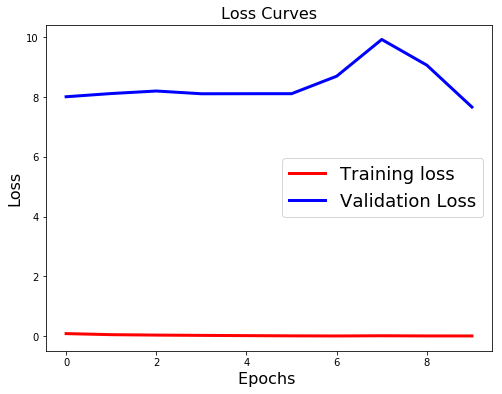

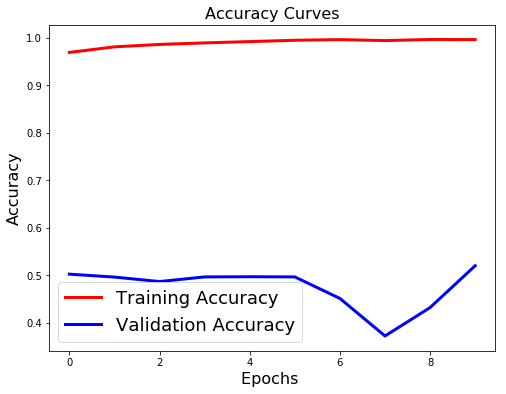

In [51]:
plot_loss_acc_curves(history)

In [52]:
classes=model.predict(test_x,batch_size=128)

In [53]:
y_classes = classes.argmax(axis=-1)
y_classes

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

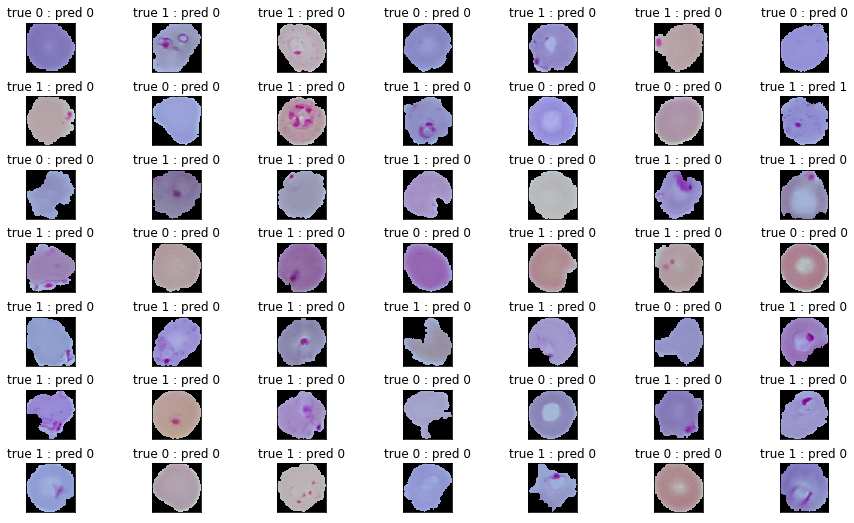

In [54]:
plt.figure(1 , figsize = (15 , 9))
n = 0 
for i in range(49):
    n += 1 
    r = np.random.randint( 0  , test_x.shape[0] , 1)
    plt.subplot(7 , 7 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.imshow(test_x[r[0]])
    plt.title('true {} : pred {}'.format(test_y1[r[0]] , y_classes[r[0]]) )
    plt.xticks([]) , plt.yticks([])

plt.show()